**Import Python Packages**

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

## Demographic Data Processing

The functions below retrieve block level data for a state using the state fips code from census API, then retrieves data from appropriate
columns in GEOID, convert to .csv to easily manipulate individual state data

In [2]:
#code chunk by Melisande Teng 

variables = [
    # pop
    "P001001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN ",
    "H_ASIAN",
    "H_NHPI ",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]


def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [3]:
#Specify MI code to pull demographic data at block level
demographic_block_data = block_data_for_state('26')
#Now we have the block data by county 

**Read in shapefile**

In [4]:
#Read Census block shapefiles
#Source: (https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Blocks)
blocks_2010_shp = gpd.read_file("tl_2010_26_tabblock10/tl_2010_26_tabblock10.shp")

In [5]:
#Given that the demographic df and demographic gdf have the same number of rows, want 
#to check to see if geoids overlap
d_df = demographic_block_data
d_gdf = blocks_2010_shp
gdf_set = set(d_gdf.GEOID10.str.lower().unique())
df_set = set(d_df.geoid.str.lower().unique())
difference = df_set.symmetric_difference(gdf_set)
intersection = gdf_set.intersection(df_set)

In [6]:
len(d_df)

329885

In [7]:
len(df_set.intersection(gdf_set))
#So, the length of the set is the same as the number of geoids
#indicates they all match, so should be good to join

329885

**Join data with shape (block level demographic data with block level shapefile)**

In [8]:
demographic_block = d_gdf.merge(d_df, how = 'inner', left_on = 'GEOID10', right_on = 'geoid', indicator = True)

In [9]:
print(len(demographic_block.GEOID10))
print(len(d_gdf.GEOID10))
print(demographic_block.TOTPOP.sum())
print(d_df.TOTPOP.sum())

329885
329885
9883640
9883640


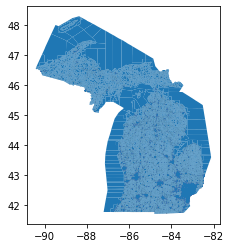

In [10]:
demographic_block.plot()

**Prorate demographic and Voting Population data from census block level to precinct level**
< "Prorate" 

In [11]:
#2016 PRECINCTS
precincts = gpd.read_file("2016_Voting_Precincts-shp/2016_Voting_Precincts.shp")

In [12]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("./MI_precincts/MI_precincts.shp")

**Demographic and Voting Pop Data from Block Level to Precinct Level**

In [13]:
precincts.crs

<Projected CRS: EPSG:3078>
Name: NAD83 / Michigan Oblique Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Michigan
- bounds: (-90.42, 41.69, -82.13, 48.32)
Coordinate Operation:
- name: Michigan Oblique Mercator (meters)
- method: Hotine Oblique Mercator (variant A)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
proj =  {'init':'epsg:4326'}
proj = precincts.crs
precincts = precincts.to_crs(proj)
demographic_block = demographic_block.to_crs(proj)

In [15]:
demographic_block.columns = demographic_block.columns.str.strip()

In [17]:
precincts.head(1)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."


In [18]:
set(mggg_final_shp.columns) - set(demographic_block.columns)

{'CD',
 'CountyFips',
 'ElectionYe',
 'HDIST',
 'Jurisdicti',
 'Label',
 'PRES16D',
 'PRES16G',
 'PRES16L',
 'PRES16R',
 'SENDIST',
 'ShapeSTLen',
 'VTD',
 'VTD2016_x',
 'county_fip',
 'county_lat',
 'county_lon',
 'county_nam',
 'jurisdic_1',
 'precinct'}

In [19]:
precincts['geometry'] = precincts.buffer(0)

In [20]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

demo_variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', 'VAP', 'HVAP', 
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP'] 

demographic_precinct = maup.assign(demographic_block, precincts)

In [21]:
precincts[demo_variables] = demographic_block[demo_variables].groupby(demographic_precinct).sum()

In [22]:
precincts.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HISP,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,57,1572,38,1330,75,2,20,0,6,101
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,57,1992,43,1760,41,3,16,0,1,128
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,64,2283,48,2024,43,2,30,1,3,132
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20...",...,50,1307,35,1160,33,1,8,2,6,62
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20...",...,29,1485,21,1316,27,2,16,0,0,103


In [23]:
precincts.TOTPOP.sum()

9883640

**Assign precincts to Senate Districts using maup**

In [24]:
#Senate Districts
####MGGG includes senate as "SENDIST" to present the 2011 enacted senate district IDs 
senate_districts = gpd.read_file("tl_2011_26_sldu/tl_2011_26_sldu.shp")

In [25]:
senate_districts.head()

,STATEFP,SLDUST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,26,032,26032,State Senate District 32,LU,2010,G5210,N,3544598561,49207378,+43.3144336,-084.2815131,"POLYGON ((-83.97394 43.52329, -83.96779 43.523..."
1,26,021,26021,State Senate District 21,LU,2010,G5210,N,4132805449,3916054903,+42.0800198,-086.4581424,"POLYGON ((-85.96515 41.75996, -85.96795 41.759..."
2,26,020,26020,State Senate District 20,LU,2010,G5210,N,1634946080,54505667,+42.2411689,-085.5647665,"POLYGON ((-85.76400 42.13104, -85.76424 42.141..."
3,26,037,26037,State Senate District 37,LU,2010,G5210,N,14964533699,15423069409,+45.7073805,-084.6195485,"POLYGON ((-85.33291 44.79862, -85.33290 44.798..."
4,26,024,26024,State Senate District 24,LU,2010,G5210,N,5059533913,2683914021,+42.5984030,-085.8112138,"POLYGON ((-85.99465 42.41896, -85.99596 42.418..."


In [26]:
senate_districts = senate_districts.to_crs(proj)

In [27]:
sd_precinct = maup.assign(precincts, senate_districts)

In [28]:
print(sd_precinct.unique())

[30  8  5  4  3 10  7  1  6 22 19 20 21  0 15 16 18  2 36 34 35 37 23 24
 25  9 17 33 32 29 26 27 31 28 13 11 14 12]


In [29]:
#no '0' district, so add 1 to IDs
sd_precinct = sd_precinct + 1.0

In [30]:
# Assign senate districts to precinct shapefile
precincts['SENDIST'] = sd_precinct

In [31]:
#confirm what it looks like
precincts['SENDIST'].nunique()

38

**Assign house districts to precincts using maup**

In [32]:
#State House of Representatives
#MGGG uses "HDIST" to represent 2011 enacted house plans
congressional_districts = gpd.read_file("tl_2011_26_sldl/tl_2011_26_sldl.shp")

In [33]:
congressional_districts.head()

,STATEFP,SLDLST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,26,098,26098,State House District 98,LL,2010,G5220,N,1112688263,20224890,+43.4119307,-084.2345730,"POLYGON ((-83.97394 43.52329, -83.96779 43.523..."
1,26,094,26094,State House District 94,LL,2010,G5220,N,982458210,19105502,+43.3030887,-083.9582146,"POLYGON ((-84.17061 43.45253, -84.17061 43.462..."
2,26,095,26095,State House District 95,LL,2010,G5220,N,292245702,9872663,+43.3895144,-083.9174552,"POLYGON ((-83.81667 43.34949, -83.81666 43.349..."
3,26,080,26080,State House District 80,LL,2010,G5220,N,1756368818,3819297751,+42.2806954,-086.3376517,"POLYGON ((-85.99596 42.41897, -85.99465 42.418..."
4,26,081,26081,State House District 81,LL,2010,G5220,N,1433103685,284194383,+42.9909507,-082.8390301,"POLYGON ((-82.41988 43.00231, -82.42273 43.000..."


In [34]:
congressional_districts = congressional_districts.to_crs(proj)

In [35]:
cd_precinct = maup.assign(precincts, congressional_districts)

In [36]:
# Add 1 to assignments
cd_precinct += 1

cd_precinct

0       76
1       76
2       76
3       92
4       92
        ..
4805    59
4806    59
4807    59
4808    59
4809    59
Length: 4810, dtype: int64

In [37]:
precincts['HDIST'] = cd_precinct

In [38]:
precincts.columns

Index(['OBJECTID', 'Id', 'VTD2016', 'CountyFips', 'Jurisdicti', 'ElectionYe',
       'Label', 'ShapeSTAre', 'ShapeSTLen', 'geometry', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP',
       'OTHERVAP', '2MOREVAP', 'SENDIST', 'HDIST'],
      dtype='object')

In [39]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("MI_precincts/MI_precincts.shp")

In [40]:
mggg_final_shp.shape

(4809, 44)

## Presidential ELECTION PROCESSING

**Import 2016 Election Data: Shape Files (gdf)**

In [41]:
#Precinct and congressional district shapefiles from State of MI GIS portal
#Source: State of Michigan GIS Open Data Portal(http://gis-michigan.opendata.arcgis.com/datasets/2016-voting-precincts?geometry=94.224%2C43.115%2C-91.752%2C84.203)
precincts_shp_2016 = gpd.read_file("2016_Voting_Precincts-shp/2016_Voting_Precincts.shp")

In [42]:
precincts_shp_2016.shape  # all geo information

(4810, 10)

**Modify the labels** to match gdf (shapefile) to df (election results)

In [43]:
# combine to use multiple variables:
def precinct_mod(row):
    label = row['Label']
    vtd2016 = row['VTD2016']
    
    if 'City of' in label:
        replace_label = label.replace("City of", "")
        replace_label = replace_label.lstrip() + " City"
        
    elif 'Township' in label:
        replace_label = label.upper()
        
    ward = vtd2016[-5:-3]
    precinct_num = vtd2016[-3:].lstrip("0")
    if ward != '00':
        ward = ward.lstrip("0")
        replace_label = replace_label.lstrip() + "; Ward " + ward + "; Precinct " + precinct_num
    elif ward == '00':
        replace_label = replace_label.lstrip() + "; " + precinct_num
    return replace_label.upper()
         
        #switched to upper case to match the df

Test of the modification

In [44]:
precincts_shp_2016.apply(precinct_mod, axis = 1)

0         DEARBORN CITY; 1
1         DEARBORN CITY; 2
2         DEARBORN CITY; 3
3         DEARBORN CITY; 4
4         DEARBORN CITY; 5
               ...        
4805     GENOA TOWNSHIP; 7
4806    OCEOLA TOWNSHIP; 5
4807    OCEOLA TOWNSHIP; 1
4808    OCEOLA TOWNSHIP; 2
4809    OCEOLA TOWNSHIP; 4
Length: 4810, dtype: object

In [45]:
gdf = precincts_shp_2016
gdf['Label'] = gdf.apply(precinct_mod, axis = 1)
gdf.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."
1,2,3889,1632100000002,163,21000,2016,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20..."
2,3,3890,1632100000003,163,21000,2016,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20..."
3,4,3891,1632100000004,163,21000,2016,DEARBORN CITY; 4,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20..."
4,5,3892,1632100000005,163,21000,2016,DEARBORN CITY; 5,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20..."


### Reading 2016 Election Data Files/dataframe (df)

In [46]:
#2016 precinct-level election data - all offices all states
precinct_election_data = pd.read_csv("2016-precinct-president.csv", 
                                     encoding='ISO-8859-1',
                                     dtype = {"county_name" : "str","precinct" : "str","district" : "str"},
                                    low_memory=False)
#specified datatype for specific columns due to error message

In [47]:
precinct_election_data.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P20003984,"STEIN, JILL",NaN,NaN,NaN,NaN
3,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",NaN,NaN,NaN,NaN
4,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#Filter to return data only for MI
mi_precinct_election = precinct_election_data[precinct_election_data.state_fips == 26]

In [49]:
mi_precinct_election.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

Testing out dataset, investigating

In [50]:
mi_precinct_election['precinct'].nunique()

4794

In [51]:
#Number of unique precincts in each county 
foo = mi_precinct_election.groupby('county_name').precinct.nunique()
foo
#foo is a variable used to represent an unspecified entity

county_name
Alcona County         13
Alger County          11
Allegan County        46
Alpena County         18
Antrim County         17
                    ... 
Tuscola County        32
Van Buren County      34
Washtenaw County     142
Wayne County        1172
Wexford County        21
Name: precinct, Length: 83, dtype: int64

In [52]:
mi_precinct_election.office.unique() # Test to make sure we are only looking at presidential race

array(['US President'], dtype=object)

Pivot df

In [53]:
mi_party = mi_precinct_election[
    (mi_precinct_election.party == 'democratic')|
    (mi_precinct_election.party == 'republican')|
    (mi_precinct_election.party == 'libertarian')|
    (mi_precinct_election.party == 'green')]



In [54]:
df = mi_pivot = mi_party.pivot_table(index = ['county_name','precinct'],
                         columns = ['party'],
                        values = ['votes'],
                         aggfunc = 'sum').reset_index()
#"reset_index" turns assigned indices into columns so that mask can be applied


Testing out dataset, investigating

In [55]:
#See how the election data is presented for example county
newdf = df[df['county_name'] == 'Alger County']
newdf

county_name                  precinct      votes                    \
party                                         democratic green libertarian   
13     Alger County      AU TRAIN TOWNSHIP; 1        199     6          28   
14     Alger County          BURT TOWNSHIP; 1        101     6          16   
15     Alger County  GRAND ISLAND TOWNSHIP; 1         15     0           2   
16     Alger County     LIMESTONE TOWNSHIP; 1         75     3           7   
17     Alger County       MATHIAS TOWNSHIP; 1        111     3          11   
18     Alger County          MUNISING CITY; 1        441    23          42   
19     Alger County      MUNISING TOWNSHIP; 1        166     6          18   
20     Alger County      MUNISING TOWNSHIP; 2        158     6          13   
21     Alger County         ONOTA TOWNSHIP; 1        121     4          13   
22     Alger County    ROCK RIVER TOWNSHIP; 1        276    10          27   
23     Alger County   Statistical Adjustments          0     0           0   

                  
party republican  
13           396  
14           200  
15             9  
16           135  
17           108  
18           518  
19           345  
20           422  
21           138  
22           314  
23             0

**Remove Statistical Adjustment** rows from dataset to just get the votes

In [56]:
mask = df[df.precinct == "Statistical Adjustments"]
mask.shape

(56, 6)

In [57]:
#mask to remove statistical adjustment - filter on false
remove_stat_adjust = df[(df.precinct != 'Statistical Adjustments')]
remove_stat_adjust

county_name                  precinct      votes                    \
party                                           democratic green libertarian   
0       Alcona County        ALCONA TOWNSHIP; 1        199     2          13   
1       Alcona County     CALEDONIA TOWNSHIP; 1        178     4          14   
2       Alcona County        CURTIS TOWNSHIP; 1        214    13           8   
3       Alcona County     GREENBUSH TOWNSHIP; 1        256     4          22   
4       Alcona County        GUSTIN TOWNSHIP; 1         80     6          16   
...               ...                       ...        ...   ...         ...   
5071   Wexford County         SELMA TOWNSHIP; 1        322    14          36   
5072   Wexford County        SLAGLE TOWNSHIP; 1         92     0          12   
5073   Wexford County  SOUTH BRANCH TOWNSHIP; 1         76     3           5   
5074   Wexford County   SPRINGVILLE TOWNSHIP; 1        176    10          28   
5076   Wexford County       WEXFORD TOWNSHIP; 1        110     7          17   

                  
party republican  
0            500  
1            441  
2            401  
3            501  
4            249  
...          ...  
5071         729  
5072         179  
5073         127  
5074         494  
5076         357  

[5021 rows x 6 columns]

In [58]:
df.shape

(5077, 6)

In [59]:
#Column sums - see election results by party
df.sum()

             party      
county_name                 Alcona CountyAlcona CountyAlcona CountyAlcona ...
precinct                    ALCONA TOWNSHIP; 1CALEDONIA TOWNSHIP; 1CURTIS ...
votes        democratic                                               2268839
             green                                                      51463
             libertarian                                               172136
             republican                                               2279543
dtype: object

In [60]:
#Evaluating data, looking to account for differences
for precinct in mi_precinct_election['precinct']:
    if 'Ward' in precinct:
        print(precinct)

HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HARRISVILLE CITY; Ward 1; Precinct 1
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 12
HOLLAND CITY; Ward 5; Precinct 11
HOLLAND CITY; Ward 5; Precinct 11
HOLLAND C

WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
WALKER CITY; Ward 2; Precinct 6
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
KENTWOOD CITY; Ward 2; Precinct 10
GRAND RAPIDS CITY; Ward 1; Precinct 12
GRAND RAPIDS CITY; Ward 1; Precinct 12
GRAND RAPIDS CITY; Ward 1; Precinct 12
GRAND RAPIDS

OWOSSO CITY; Ward 2; Precinct 1
OWOSSO CITY; Ward 2; Precinct 1
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 2
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 2; Precinct 4
OWOSSO CITY; Ward 1; Precinct 1
OWOSSO CITY; Ward 1; Precinct 1
OWOSSO CITY; Ward 1; Precinct 1
OWOSSO C

**---**

**More Data Processing**

In [61]:
from reference_data import geoid_to_county_name
#geoid_to_county_name

In [62]:
#Finding number of "Charter Township" Labels to see if this accounts for discrepency (Charter does not appear in df)
#Mask to remove "Charter" rows from dataset
remove_charter = gdf[(gdf.Label != 'Charter')]
remove_charter
#did not work to remove^

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."
1,2,3889,1632100000002,163,21000,2016,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20..."
2,3,3890,1632100000003,163,21000,2016,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20..."
3,4,3891,1632100000004,163,21000,2016,DEARBORN CITY; 4,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20..."
4,5,3892,1632100000005,163,21000,2016,DEARBORN CITY; 5,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20..."
...,...,...,...,...,...,...,...,...,...,...
4805,4806,1805,0933186000007,093,31860,2016,GENOA TOWNSHIP; 7,6.610719e+06,18986.630070,"POLYGON ((678019.208 220453.671, 677984.088 22..."
4806,4807,1848,0936012000005,093,60120,2016,OCEOLA TOWNSHIP; 5,8.526046e+06,12408.612226,"POLYGON ((674226.582 230029.619, 674205.136 23..."
4807,4808,1848,0936012000001,093,60120,2016,OCEOLA TOWNSHIP; 1,4.258013e+07,28101.267509,"POLYGON ((674058.491 233218.627, 673972.280 23..."
4808,4809,1848,0936012000002,093,60120,2016,OCEOLA TOWNSHIP; 2,7.200447e+06,13280.921753,"POLYGON ((672258.795 232398.214, 672291.130 23..."


In [63]:
precincts_shp_2016.Id.nunique()


4769

**--**

In [64]:
# intersect
gdf_set = set(gdf.Label.str.lower().unique())
df_set = set(df.precinct.str.lower().unique())
difference = df_set.symmetric_difference(gdf_set)
intersection = gdf_set.intersection(df_set)

In [65]:
print(len(gdf_set))
print(len(df_set))
print("unmatched_df: ", len(df_set) - len(intersection))
print("unmatched_gdf: ", len(gdf_set) - len(intersection))
unmatched_df = (len(df_set) - len(intersection))
unmatched_gdf = (len(gdf_set) - len(intersection))
print("Difference in missing data: ", unmatched_df - unmatched_gdf)
print("Total difference between gdf and df: ", (len(df_set) - len(gdf_set)))
#So this means that the unmatched data contains the differences between the two
#If not the leading spaces, what is the difference?

4586
4794
unmatched_df:  1175
unmatched_gdf:  967
Difference in missing data:  208
Total difference between gdf and df:  208


In [66]:
len(difference)

2142

Uncomment below to see differences between datasets 

In [67]:
#sorted(difference)   #Commented out because output is so long

In [68]:
#df_set   #Commented out because output is so long

In [69]:
#gdf_set   #Commented out because output is so long

**Almost half of the items in the datasets do not match up**
as can be seen by the length of the difference between the datasets

This is caused by inconsistencies in the naming conventions which can be observed in the line below in the alphabetically sorted difference set. The discrepencies come from a wide range of differences in name format. MGGG did not post their processing steps for the public, so here at the RDH we were not able to replicate their results. 

Examples include but are not limited to:

'Mount' vs 'Mt'
'|avcb' vs normal precinct name
'city city' vs 'city'
'ward x; precinct y' vs 'precinct x'

## Final MGGG Shapefile - compare

In [70]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("./MI_precincts/MI_precincts.shp")

In [71]:
precincts.head(1)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SENDIST,HDIST
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,38,1330,75,2,20,0,6,101,31.0,76


**Number of rows in shapefile and final MGGG final match, accounting for the extra row header in gdf**

In [72]:
len(mggg_final_shp)

4809

In [73]:
mit_presd = df['votes','democratic'].sum()
mggg_presd = mggg_final_shp['PRES16D'].sum()
print("Democrat results percent difference = ", 100*(mit_presd - mggg_presd)/mit_presd, "%" )

mit_presg = df['votes','green'].sum()
mggg_presg = mggg_final_shp['PRES16G'].sum()
print("Green Pary results percent difference = ", 100*(mit_presg - mggg_presg)/mit_presg, "%" )

mit_presl = df['votes','libertarian'].sum()
mggg_presl = mggg_final_shp['PRES16L'].sum()
print("Libertarian results percent difference = ", 100*(mit_presl - mggg_presl)/mit_presl, "%" )

mit_presr = df['votes','republican'].sum()
mggg_presr = mggg_final_shp['PRES16R'].sum()
print("Republican results percent difference = ", 100*(mit_presr - mggg_presr)/mit_presr, "%" )

Democrat results percent difference =  2.5903556841186175 %
Green Pary results percent difference =  0.6140333832073529 %
Libertarian results percent difference =  0.40607426685876286 %
Republican results percent difference =  0.4176714367748272 %


-

**Comparing demographic data from Census with MGGG final file***

In [74]:
precs = precincts
preclabel = precs.sort_values(by = 'Label', ascending = True) 
preclabel.head(4)


,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SENDIST,HDIST
909,910,876,0550020000001,055,00200,2016,Acme Township,4.340977e+07,31100.241154,"POLYGON ((539215.085 469215.589, 539262.120 46...",...,30,2220,5,18,8,0,0,21,4.0,96
910,911,877,0550020000002,055,00200,2016,Acme Township,8.660255e+07,42415.618327,"POLYGON ((545522.077 478833.967, 545546.951 47...",...,13,1087,3,3,5,0,1,8,4.0,96
1454,1455,1423,0810024000008,081,00240,2016,Ada Township,2.714254e+07,30882.043774,"POLYGON ((544841.968 269984.489, 544898.886 26...",...,18,1164,5,2,16,0,0,6,37.0,104
1453,1454,1422,0810024000007,081,00240,2016,Ada Township,5.186158e+06,15426.487486,"POLYGON ((539230.196 268118.769, 539518.938 26...",...,12,881,11,2,29,1,0,12,37.0,104


In [77]:
mglabel = mggg_final_shp.sort_values(by = 'Label', ascending = True) 
mglabel.head(4)

,VTD2016_x,ShapeSTLen,CountyFips,Jurisdicti,ElectionYe,Label,VTD,county_nam,county_fip,county_lat,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,HDIST,SENDIST,CD,geometry
4117,0550020000001,31100.241154,055,00200,2016,Acme Township,P0550020000001,Grand Traverse County,26055,44.718688,...,5.000000,17.999999,8.000000,0.0,0.000000e+00,20.997988,104,037,01,"POLYGON ((-85.50238 44.77351, -85.50179 44.773..."
1063,0550020000002,42415.618327,055,00200,2016,Acme Township,P0550020000002,Grand Traverse County,26055,44.718688,...,2.999997,2.999960,4.999960,0.0,1.000000e+00,7.999628,104,037,01,"POLYGON ((-85.42181 44.85972, -85.42170 44.839..."
1548,0810024000008,30882.043774,081,00240,2016,Ada Township,P0810024000008,Kent County,26081,43.032497,...,5.032402,1.999629,16.031725,0.0,2.436513e-09,5.999629,086,029,03,"POLYGON ((-85.44843 42.97942, -85.44773 42.979..."
1117,0810024000007,15426.487486,081,00240,2016,Ada Township,P0810024000007,Kent County,26081,43.032497,...,10.999163,1.999558,28.999700,1.0,0.000000e+00,11.998176,086,029,03,"POLYGON ((-85.51739 42.96295, -85.51385 42.962..."


Above, can see that the first few labels match, and that the demographic data appears to approximately match, though MGGG has floating decimals 

In [78]:
#Merge using the precinct code: VTD_2016
overlap = pd.merge(preclabel, mglabel, how = 'inner', left_on = 'VTD2016', right_on = 'VTD2016_x')

In [79]:
overlap.shape

(4809, 74)

In [80]:
overlap.columns

Index(['OBJECTID', 'Id', 'VTD2016', 'CountyFips_x', 'Jurisdicti_x',
       'ElectionYe_x', 'Label_x', 'ShapeSTAre', 'ShapeSTLen_x', 'geometry_x',
       'TOTPOP_x', 'NH_WHITE_x', 'NH_BLACK_x', 'NH_AMIN_x', 'NH_ASIAN_x',
       'NH_NHPI_x', 'NH_OTHER_x', 'NH_2MORE', 'HISP_x', 'VAP_x', 'HVAP_x',
       'WVAP_x', 'BVAP_x', 'AMINVAP_x', 'ASIANVAP_x', 'NHPIVAP_x',
       'OTHERVAP_x', '2MOREVAP_x', 'SENDIST_x', 'HDIST_x', 'VTD2016_x',
       'ShapeSTLen_y', 'CountyFips_y', 'Jurisdicti_y', 'ElectionYe_y',
       'Label_y', 'VTD', 'county_nam', 'county_fip', 'county_lat',
       'county_lon', 'jurisdic_1', 'precinct', 'PRES16D', 'PRES16R', 'PRES16L',
       'PRES16G', 'TOTPOP_y', 'NH_WHITE_y', 'NH_BLACK_y', 'NH_AMIN_y',
       'NH_ASIAN_y', 'NH_NHPI_y', 'NH_OTHER_y', 'HISP_y', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'VAP_y', 'HVAP_y', 'WVAP_y',
       'BVAP_y', 'AMINVAP_y', 'ASIANVAP_y', 'NHPIVAP_y', 'OTHERVAP_y',
       '2MOREVAP_y', 'HDIST_y', 'SENDIST_y', 'CD

In [81]:
import math

In [91]:
def match(row, mggg_col, prec_col):
    mggg_value = row[mggg_col]
    prec_value = row[prec_col]
    
    return math.ceil(mggg_value) == prec_value or math.floor(mggg_value) == prec_value

In [93]:
mggg_col = 'TOTPOP_y'
prec_col = 'TOTPOP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

False    4762
True       47
dtype: int64

In [94]:
mggg_col = 'NH_WHITE_y'
prec_col = 'NH_WHITE_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

False    4737
True       72
dtype: int64

In [95]:
mggg_col = 'NH_BLACK_y'
prec_col = 'NH_BLACK_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

False    4429
True      380
dtype: int64

In [97]:
mggg_col = 'NH_ASIAN_y'
prec_col = 'NH_ASIAN_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

False    4046
True      763
dtype: int64

In [98]:
mggg_col = 'NH_NHPI_y'
prec_col = 'NH_NHPI_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     3076
False    1733
dtype: int64

In [96]:
mggg_col = 'NH_AMIN_y'
prec_col = 'NH_AMIN_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

False    4635
True      174
dtype: int64

In [99]:
mggg_col = 'NH_OTHER_y'
prec_col = 'NH_OTHER_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     2532
False    2277
dtype: int64

In [101]:
mggg_col = 'HISP_y'
prec_col = 'HISP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

False    3849
True      960
dtype: int64

In [102]:
mggg_col = 'VAP_y'
prec_col = 'VAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     3831
False     978
dtype: int64

In [103]:
mggg_col = 'HVAP_y'
prec_col = 'HVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     4725
False      84
dtype: int64

In [104]:
mggg_col = 'WVAP_y'
prec_col = 'WVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     4101
False     708
dtype: int64

In [105]:
mggg_col = 'AMINVAP_y'
prec_col = 'AMINVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     4802
False       7
dtype: int64

In [106]:
mggg_col = 'ASIANVAP_y'
prec_col = 'ASIANVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     4738
False      71
dtype: int64

In [107]:
mggg_col = 'NHPIVAP_y'
prec_col = 'NHPIVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True    4809
dtype: int64

In [89]:
mggg_col = 'BVAP_y'
prec_col = 'BVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     4553
False     256
dtype: int64

In [108]:
mggg_col = 'OTHERVAP_y'
prec_col = 'OTHERVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     4805
False       4
dtype: int64

In [109]:
mggg_col = '2MOREVAP_y'
prec_col = '2MOREVAP_x'
overlap.apply(lambda row: match(row, mggg_col, prec_col), axis=1).value_counts()

True     4772
False      37
dtype: int64

### Validation

We see that while some categories of demographic data are quite close, NHPIVAP is the only category that perfectly matches up, and a handful of categories contain very little overlap between MGGG's final dataset, and our recreation.

The 2016 presidential vote counts are very close between the two data sets - below 1% for all parties except democratic which is 2.3% different. 

The RDH was not able to recreate MGGG's final dataset due to a diverse set of discrepencies in naming conventions between the raw election results and raw shapefile. The number of differences makes it difficult to detect MGGG's processing steps for different cases. For examples, see note below In[66]. 
